- tf.Dataset
- batchsize
- Sequential 
- callback (niektóre)
- krzywe uczenia
- zapisywanie/odczytywanie modeli
- regresja/klasyfikacja (autompg/kotki)
- random seed


# Imports

In [1]:
!pip install pyyaml h5py # to include?

ERROR: Invalid requirement: '#'


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras as krs
import seaborn as sns

from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.layers import (
    Dense, 
    Conv2D,
    Flatten,
    Input,
    MaxPooling2D,
    Dropout,
    Rescaling
)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

sns.set_style('darkgrid')

# Regression

## Data

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls"

df = pd.read_excel(url)
df.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [4]:
df.columns = ['Cement', 'Slag', 'Ash', 'Water', 'Plasticizer', 'Coarse', 'Fine', 'Age', 'Concrete']

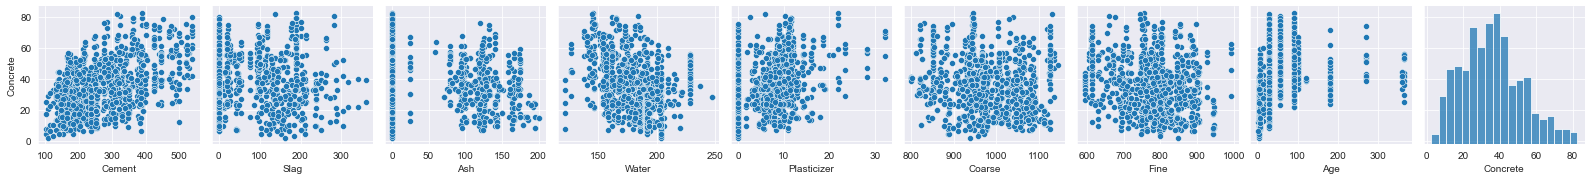

In [5]:
sns.pairplot(df, y_vars=df.iloc[:, -1:].columns)

## Splitting

In [6]:
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)

In [7]:
train_X, train_y = train_df.iloc[:, :-1], train_df.iloc[:, -1]

In [8]:
test_X, test_y = test_df.iloc[:, :-1], test_df.iloc[:, -1]

## Keras Sequential API

### Simple Model

![simple_nn](media\simple_nn.svg)

In [9]:
train_column = 'Age'
simple_train = np.array(train_df[train_column])
simple_test = np.array(test_df[train_column])

In [12]:
simple_normalizer = layers.Normalization(input_shape=[1,], axis=None)
simple_normalizer.adapt(simple_train)

In [13]:
simple_train[:10], simple_normalizer(simple_train)[:10]

(array([365,   7,  28,   3,  28,  28,  28, 100,  28,  90], dtype=int64),
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([ 5.013903  , -0.6005111 , -0.2711739 , -0.6632419 , -0.2711739 ,
        -0.2711739 , -0.2711739 ,  0.85798204, -0.2711739 ,  0.7011548 ],
       dtype=float32)>)

In [14]:
simple_model = krs.Sequential()
simple_model.add(simple_normalizer)
simple_model.add(layers.Dense(1))

simple_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 1)                3         
 n)                                                              
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [15]:
simple_model = krs.Sequential([
    simple_normalizer,
    layers.Dense(1)
])

simple_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 1)                3         
 n)                                                              
                                                                 
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [16]:
lr = .01
epochs = 250
val_frac = .25
metric = krs.losses.MeanSquaredError()

In [17]:
simple_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=lr),
    loss=metric)

In [18]:
history = simple_model.fit(simple_train, train_y, epochs=epochs, verbose=0, validation_split=val_frac)

In [19]:
training_history = pd.DataFrame(history.history)
training_history['epoch'] = history.epoch
training_history.head()

,loss,val_loss,epoch
0,1558.664185,1554.394287,0
1,1543.552734,1539.579956,1
2,1528.661743,1524.938843,2
3,1513.932251,1510.185181,3
4,1499.306030,1495.665771,4


In [20]:
training_history = pd.melt(training_history, id_vars=['epoch'], value_vars=['loss', 'val_loss'])
training_history.head()

,epoch,variable,value
0,0,loss,1558.664185
1,1,loss,1543.552734
2,2,loss,1528.661743
3,3,loss,1513.932251
4,4,loss,1499.306030


In [21]:
def process_history(history):
    
    training_history = pd.DataFrame(history.history)
    training_history['epoch'] = history.epoch
    
    return pd.melt(training_history, id_vars=['epoch'], value_vars=['loss', 'val_loss'])

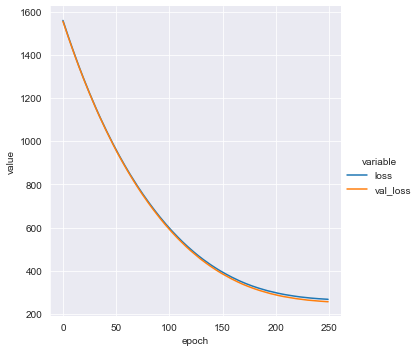

In [22]:
sns.relplot(data=training_history, x='epoch', y='value', hue='variable', kind='line')

In [23]:
simple_model.evaluate(simple_test, test_y)

7/7 [==============================] - 0s 882us/step - loss: 211.9196


211.9196014404297

In [24]:
def visualize_predictions(data, model):
    
    plot_data = data.copy()
    data['Forecast'] = model.predict(data[train_column])
    data = pd.melt(data, id_vars=[train_column], value_vars=['Concrete', 'Forecast'])
    sns.relplot(data=data, x=train_column, y='value', hue='variable', kind='scatter')

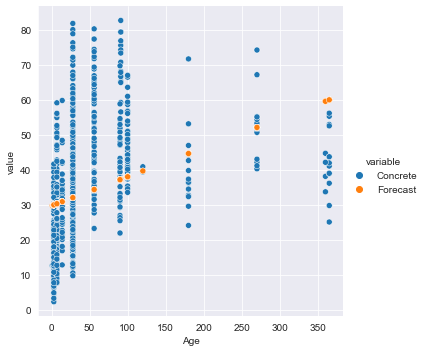

In [25]:
visualize_predictions(train_df, simple_model)

### Nonlinear Model

![deep_nn](media\deep_nn.svg)

In [26]:
hidden_size = 16
activation = 'relu'

![activations](media\activations.png)

In [28]:
nonlinear_model = krs.Sequential([
    simple_normalizer,
    layers.Dense(hidden_size, activation=activation),
    layers.Dense(1)
])

nonlinear_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 1)                3         
 n)                                                              
                                                                 
 dense_2 (Dense)             (None, 16)                32        
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 52
Trainable params: 49
Non-trainable params: 3
_________________________________________________________________


In [29]:
lr = 1e-3

In [30]:
nonlinear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=lr),
    loss=metric)

In [31]:
nonlinear_history = process_history(
    nonlinear_model.fit(simple_train, train_y, epochs=epochs, verbose=0, validation_split=val_frac))

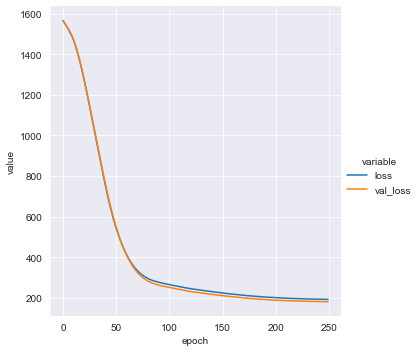

In [32]:
sns.relplot(data=nonlinear_history, x='epoch', y='value', hue='variable', kind='line')

In [33]:
nonlinear_model.evaluate(simple_test, test_y)

7/7 [==============================] - 0s 1ms/step - loss: 165.7641


165.76405334472656

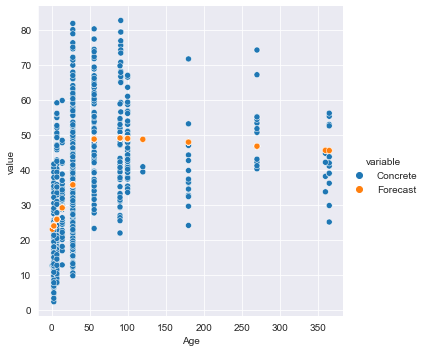

In [34]:
visualize_predictions(train_df, nonlinear_model)

## Keras Functional API

![full_nn](media\full_nn.svg)

In [35]:
inputs = krs.Input(shape=(train_X.shape[1],))

In [36]:
normalizer = layers.Normalization(axis=-1)
x = normalizer(inputs)

In [37]:
dense = layers.Dense(hidden_size, activation='relu')
x = dense(x)

In [38]:
outputs = layers.Dense(1)(x)

In [39]:
model = krs.Model(inputs=inputs, outputs=outputs, name='full_model')
model.summary()

Model: "full_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 normalization_1 (Normalizat  (None, 8)                17        
 ion)                                                            
                                                                 
 dense_4 (Dense)             (None, 16)                144       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 178
Trainable params: 161
Non-trainable params: 17
_________________________________________________________________


In [40]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=lr),
    loss=metric)

In [41]:
history = process_history(model.fit(train_X, train_y, epochs=epochs, verbose=0, validation_split=val_frac))

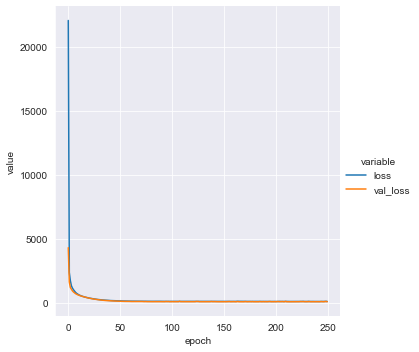

In [42]:
sns.relplot(data=history, x='epoch', y='value', hue='variable', kind='line')

In [43]:
model.evaluate(test_X, test_y)

7/7 [==============================] - 0s 2ms/step - loss: 109.3391


109.33906555175781

## Enhancements

### Dropout

![dropout](media\dropout.png)

### L1/L2 Weights Regularization

![regularization.png](media\regularization.png)

In [44]:
drop_rate = .1
regularizer = 'l1_l2'
initializer = 'he_normal'

In [45]:
enhanced_dense = layers.Dense(hidden_size, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizer)
dropout = layers.Dropout(drop_rate)
output_dense = layers.Dense(1, kernel_initializer=initializer, kernel_regularizer=regularizer)

In [46]:
simple_train[:20], dropout(np.array(simple_train, dtype='float32'), training=True)[:30]

(array([365,   7,  28,   3,  28,  28,  28, 100,  28,  90,  28,   7,   3,
          7,  14,   7,  28,   7,  28,  14], dtype=int64),
 <tf.Tensor: shape=(30,), dtype=float32, numpy=
 array([405.55557  ,   7.777778 ,   0.       ,   0.       ,  31.111113 ,
         31.111113 ,  31.111113 , 111.111115 ,  31.111113 , 100.00001  ,
         31.111113 ,   7.777778 ,   3.3333335,   7.777778 ,   0.       ,
          7.777778 ,   0.       ,   7.777778 ,  31.111113 ,   0.       ,
         31.111113 , 111.111115 ,  62.222225 ,   0.       ,  15.555556 ,
          0.       ,   0.       ,  31.111113 , 111.111115 ,   3.3333335],
       dtype=float32)>)

In [47]:
enhanced_model = krs.Sequential([
    normalizer,
    enhanced_dense,
    dropout,
    output_dense
])

In [48]:
enhanced_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=lr),
    loss=metric)

In [49]:
enhanced_history = process_history(enhanced_model.fit(train_X, train_y, epochs=epochs, verbose=0, validation_split=val_frac))

In [50]:
enhanced_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 8)                17        
 ion)                                                            
                                                                 
 dense_6 (Dense)             (None, 16)                144       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 178
Trainable params: 161
Non-trainable params: 17
_________________________________________________________________


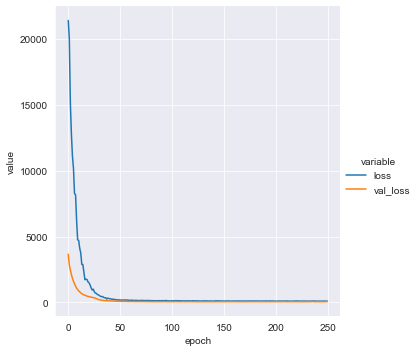

In [51]:
sns.relplot(data=enhanced_history, x='epoch', y='value', hue='variable', kind='line')

In [52]:
enhanced_model.evaluate(test_X, test_y)

7/7 [==============================] - 0s 1ms/step - loss: 52.7527


52.75267028808594

# Classification

## Data

In [53]:
# Dogs and cats light dataset
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip',  # name of downloaded zip
                                      origin=_URL, 
                                      extract=True,  # extracting files
                                      cache_dir='.') # it ensures, that it will be dwonloaded to current directory
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered') 

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

68616192/68606236 [==============================] - 2s 0us/step


### Batches

![batches](media\batches.jpg)

In [54]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [55]:
train = krs.utils.image_dataset_from_directory(train_dir,
                                               shuffle=True,
                                               batch_size=BATCH_SIZE,
                                               image_size=IMG_SIZE,
                                               seed=7)

validation = krs.utils.image_dataset_from_directory(validation_dir,
                                                   shuffle=True,
                                                   batch_size=BATCH_SIZE,
                                                   image_size=IMG_SIZE,
                                                   seed=7)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


As we can see, it will import data into tensorflow Dataset object

In [56]:
train

<BatchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [57]:
classes = train.class_names
classes

['cats', 'dogs']

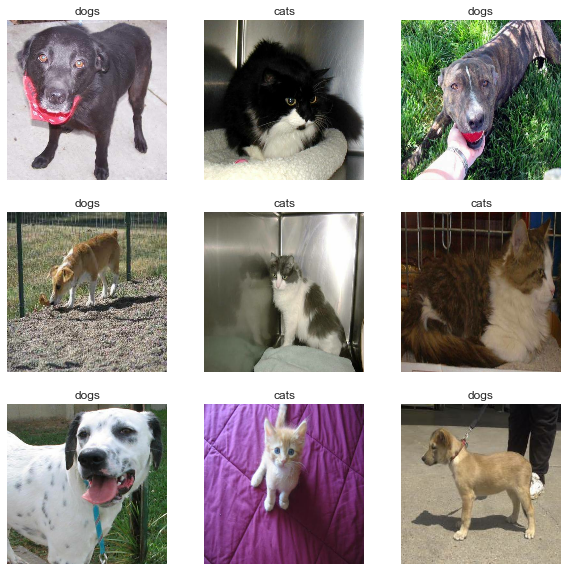

In [58]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[labels[i]])
        plt.axis("off")

In [59]:
# Number of batches in validations set
val_batches = tf.data.experimental.cardinality(validation)

# Splitting validation data into test set
test = validation.take(val_batches // 5)
validation = validation.skip(val_batches // 5)

In [60]:
tf.data.experimental.cardinality(validation)

<tf.Tensor: shape=(), dtype=int64, numpy=26>

In [61]:
tf.data.experimental.cardinality(test)

<tf.Tensor: shape=(), dtype=int64, numpy=6>

### Data prefetching

In [62]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.prefetch(buffer_size=AUTOTUNE)
validation = validation.prefetch(buffer_size=AUTOTUNE)
test = test.prefetch(buffer_size=AUTOTUNE)

![prefetch](media\prefetch.png)

## Modelling

### Convolution Layer

![prefetch](media\convolution.png)

In [63]:
def create_model():
    model = Sequential([
        Rescaling(1. / 255, input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)),
        Conv2D(32, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(16, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(8, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(len(classes))
    ])
    return model

### Max pooling

![prefetch](media\pooling.png)

In [64]:
model = create_model()

We can print summary of our model

In [65]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 160, 160, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 80, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 40, 40, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 8)        

We can observe that with `padding='same'` our convolution layers don't change the width and hight of our filters.

![prefetch](media\padding.png)

The final computer vision model pipeline looks as follows 

In [66]:
![prefetch](media\cv.png)

'[prefetch]' is not recognized as an internal or external command,
operable program or batch file.


We have to compile model

In [67]:
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Defining callbacks and fixing random seed

In [68]:
tf.random.set_seed(7)
path_to_model1 = os.path.join('models', 'model1.ckpt')
path_to_history1 = os.path.join('models', 'history1.csv')

n_epochs = 30
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(path_to_model1, ),
             CSVLogger(path_to_history1, append=True)]

In [69]:
history = model.fit(train, 
         batch_size=BATCH_SIZE,
         epochs=n_epochs,
         validation_data=validation,
         callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 35s 547ms/step - loss: 0.6932 - accuracy: 0.5320 - val_loss: 0.6862 - val_accuracy: 0.6163
Epoch 2/30
63/63 [==============================] - 33s 520ms/step - loss: 0.6807 - accuracy: 0.5880 - val_loss: 0.6843 - val_accuracy: 0.5631
Epoch 3/30
63/63 [==============================] - 31s 492ms/step - loss: 0.6260 - accuracy: 0.6630 - val_loss: 0.6267 - val_accuracy: 0.6498
Epoch 4/30
63/63 [==============================] - 32s 509ms/step - loss: 0.5620 - accuracy: 0.7265 - val_loss: 0.6220 - val_accuracy: 0.6757
Epoch 5/30
63/63 [==============================] - 31s 494ms/step - loss: 0.5222 - accuracy: 0.7435 - val_loss: 0.6556 - val_accuracy: 0.6621
Epoch 6/30
63/63 [==============================] - 33s 517ms/step - loss: 0.4588 - accuracy: 0.7800 - val_loss: 0.6429 - val_accuracy: 0.6696
Epoch 7/30
63/63 [==============================] - 33s 518ms/step - loss: 0.4138 - accuracy: 0.8135 - val_loss: 0.7431 - val_accuracy: 0.6535

We can see that data from learning are saved in history object

In [70]:
history

In [71]:
model = tf.keras.models.load_model(path_to_model1)

In [72]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 160, 160, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 80, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 40, 40, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 8)        

In [73]:
history = pd.read_csv(path_to_history1)

In [74]:
history

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.5320,0.693230,0.616337,0.686171
1,1,0.5880,0.680712,0.563119,0.684335
2,2,0.6630,0.625998,0.649752,0.626651
3,3,0.7265,0.562020,0.675743,0.622046
4,4,0.7435,0.522217,0.662129,0.655591
5,5,0.7800,0.458788,0.669554,0.642931
6,6,0.8135,0.413807,0.653465,0.743065
7,7,0.8555,0.353340,0.648515,0.795294
8,8,0.8675,0.319437,0.683168,0.757646


In [75]:
def learning_curves(history):
    if isinstance(history, pd.DataFrame):
        acc = history['accuracy']
        val_acc = history['val_accuracy']

        loss = history['loss']
        val_loss = history['val_loss']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']

        loss = history.history['loss']
        val_loss = history.history['val_loss']
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')

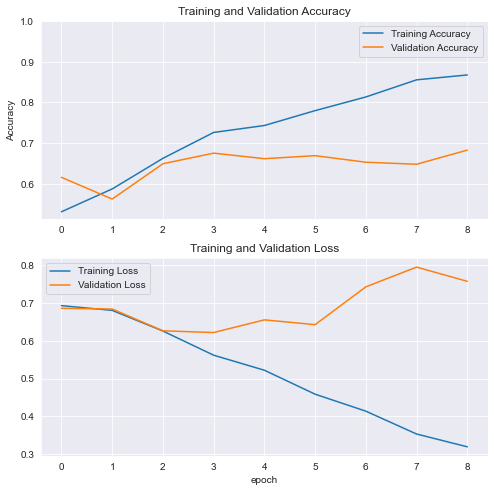

In [76]:
learning_curves(history)

In [77]:
model.evaluate(test)

6/6 [==============================] - 1s 100ms/step - loss: 0.7925 - accuracy: 0.6771


[0.7925440669059753, 0.6770833134651184]

## Second model

In [78]:
model = Sequential([
    Rescaling(1. / 255, input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.1),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.1),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.1),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.1),
    Flatten(),
    Dense(32, activation='selu'),
    Dense(len(classes))
])

In [79]:
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

tf.random.set_seed(7)
path_to_model2 = os.path.join('models', 'model2.ckpt')
path_to_history2 = os.path.join('models', 'history2.csv')

n_epochs = 30
callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
             ModelCheckpoint(path_to_model2, save_best_only=True),
             CSVLogger(path_to_history2, append=True)]

In [80]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 80, 80, 16)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 80, 80, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 80, 80, 16)        2320      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 40, 40, 16)       0         
 2D)                                                  

In [81]:
history = model.fit(train, 
         batch_size=BATCH_SIZE,
         epochs=n_epochs,
         validation_data=validation,
         callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 28s 422ms/step - loss: 0.7085 - accuracy: 0.5005 - val_loss: 0.6927 - val_accuracy: 0.5087
Epoch 2/30
63/63 [==============================] - 28s 451ms/step - loss: 0.6921 - accuracy: 0.5250 - val_loss: 0.6874 - val_accuracy: 0.5978
Epoch 3/30
63/63 [==============================] - 27s 433ms/step - loss: 0.6830 - accuracy: 0.5540 - val_loss: 0.6693 - val_accuracy: 0.5854
Epoch 4/30
63/63 [==============================] - 26s 409ms/step - loss: 0.6689 - accuracy: 0.5875 - val_loss: 0.6626 - val_accuracy: 0.5829
Epoch 5/30
63/63 [==============================] - 24s 385ms/step - loss: 0.6575 - accuracy: 0.6090 - val_loss: 0.6644 - val_accuracy: 0.5780
Epoch 6/30
63/63 [==============================] - 27s 420ms/step - loss: 0.6519 - accuracy: 0.6060 - val_loss: 0.6565 - val_accuracy: 0.5953
Epoch 7/30
63/63 [==============================] - 25s 401ms/step - loss: 0.6313 - accuracy: 0.6570 - val_loss: 0.6564 - val_accuracy: 0.5866

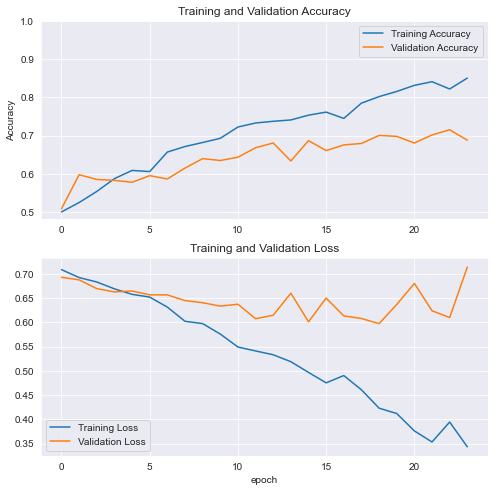

In [82]:
learning_curves(history)

In [83]:
model.evaluate(test)

6/6 [==============================] - 1s 82ms/step - loss: 0.6740 - accuracy: 0.6406


[0.6740303635597229, 0.640625]

# Further reading

Books:
 - [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow.](https://helion.pl/ksiazki/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow-concepts-tools-and-techniques-aur-lien-g-ron,e_17oi.htm#format/e)
 - [Dive Into Deep Learning](https://d2l.ai/)
 
Articles:
 - [Weights initialization techniques](https://towardsdatascience.com/weight-initialization-techniques-in-neural-networks-26c649eb3b78)
 - [Batch Normalization](https://towardsdatascience.com/batch-normalization-in-3-levels-of-understanding-14c2da90a338)
 - [Activation Functions](https://arxiv.org/abs/2101.09957)
 - [Convolutional Neural Networks for Visual Recognition](https://cs231n.github.io/convolutional-networks/)
 
[Playground](https://playground.tensorflow.org/)